In [1]:
import nbodykit as nkit
import numpy as npy
from nbodykit.source.catalog import CSVCatalog
from nbodykit.source.catalog import ArrayCatalog
from matplotlib import pyplot
import healpy as hp
import pmesh
import time
import sys;
import scipy
from importlib import reload 
import scipy as scpy
sys.path.append("/home/chris/Dropbox/Document/Metric reconstruction/")
import lcmetric
import lcmetric.metric
import lcmetric.utils as ut
import lcmetric.cgeodesic as geo
import lcmetric.clightcone_CIC as lc_CIC


In [2]:
f_path ='/media/chris/3b7ae93c-9459-4858-9b27-3209d1805b9a/draft_data/Metric_recon/'

cone_dtype = npy.double # Data type for light-cone
NR = 430 # Radial resolution. NOTE: the actual size of any light-cone mesh field is NR+2 
NSIDE = 80 #Healpix nside
NPIX = 12 * NSIDE * NSIDE #Number of pixels

# In Mpc, to convert from Mpc h^-1, multiply cosmo_paras['h'] / L_unit
# H_0 is cosmo_paras['h'] * 100 with L_unit = 3e5
L_unit = 3e5 

N_snap = 256 #snapshot mesh resolution
N_samples = 256 #snapshot number of particles

origin = npy.array([0, 0, 0.0], dtype=cone_dtype) #light-cone origin
# Setting initial cosmic parameters
cosmo_paras={'h':0.69, 'Omega_m':0.31, 'Omega_L':0.69}
init_zel_z = 9 #Redshift where n-body simulation starts
init_z = 0.5
init_a = 1/(1+init_z)
final_z = 0.03
final_a = 1/(1+final_z)

# 1/H(z)
def Hint(z, cosmo_paras):
    return 1/(cosmo_paras['h']*100*npy.sqrt(cosmo_paras['Omega_m']*(1+z)**3 + cosmo_paras['Omega_L']))

# H(z)
def H(z, cosmo_paras):
    return (cosmo_paras['h']*100/(1+z)*npy.sqrt(cosmo_paras['Omega_m']*(1+z)**3 + cosmo_paras['Omega_L']))

# integrate 1/H(z) - r, to inversely solve z for given r
def inverse_Hint(z, r, cosmo_paras):
    return npy.abs(scpy.integrate.quad(Hint, 0, z,args=(cosmo_paras))[0] - r)

# Initial comoving distance
init_r = scpy.integrate.quad(Hint, 0, init_z,args=(cosmo_paras))[0]

# Final comoving distance
final_r = scpy.integrate.quad(Hint, 0, final_z,args=(cosmo_paras))[0]

# Initial Hubble
Hi = H(init_z, cosmo_paras)

#Final Hubble
Hf = H(final_z, cosmo_paras)
H0 = cosmo_paras['h'] * 100
L_snap = 512 / cosmo_paras['h'] / L_unit
# Locating radial distance for radial mesh n
def to_r(n,nr = NR):
    return n / nr * (init_r - final_r) + final_r
def to_tau(n,nr = NR):
    return n / nr * (init_r - final_r) + final_r

In [39]:
def pots_from_lightcone(f_path, N_snap, NR):
    f = CSVCatalog(f_path+'cone_test_'+str(N_snap)+'/cone_test_'+str(N_snap)+'_lightcone.*', \
               ['x','y','z','vx','vy','vz','phi'],dtype='f8')
    f['Particles'] = (f['x'][:, None]) * npy.array([1/cosmo_paras['h']/L_unit, 0, 0, 0, 0, 0] , dtype = cone_dtype)\
    + (f['y'][:, None]) * npy.array([0, 1/cosmo_paras['h']/L_unit, 0, 0, 0, 0], dtype = cone_dtype) \
    + (f['z'][:, None]) * npy.array([0, 0, 1/cosmo_paras['h']/L_unit, 0, 0, 0], dtype = cone_dtype)\
    + (f['phi'][:, None]) * npy.array([0, 0, 0, 1, 0, 0], dtype = cone_dtype) \
    + (f['vy'][:, None]) * npy.array([0, 0, 0, 0, 1/3e5, 0], dtype = cone_dtype) \
    + (f['vz'][:, None]) * npy.array([0, 0, 0, 0, 0, 1/3e5], dtype = cone_dtype) 

    f.attrs['BoxSize'] = L_snap 
    f['Particles']=f['Particles'].rechunk(20000000)
    # Creating healpy coordinate list in cartesian coordinate
    theta_list, phi_list = hp.pix2ang(NSIDE, range(12*NSIDE**2))
    x_list = npy.array([ \
                         init_r * npy.sin(theta_list) * npy.cos(phi_list) + origin[0],        \
                         init_r * npy.sin(theta_list) * npy.sin(phi_list) + origin[1],        \
                         init_r * npy.cos(theta_list) + origin[2]                             \
    ])
    x_list = npy.ascontiguousarray(npy.transpose(x_list))

    xf_list = npy.array([ \
                         final_r * npy.sin(theta_list) * npy.cos(phi_list) + origin[0],        \
                         final_r * npy.sin(theta_list) * npy.sin(phi_list) + origin[1],        \
                         final_r * npy.cos(theta_list) + origin[2]                             \
    ])
    xf_list = npy.ascontiguousarray(npy.transpose(xf_list))
    
    delta = npy.zeros((NR+2,NPIX),dtype= cone_dtype)
    delta.fill(-1)
    phi_cone = npy.zeros((NR+2, NPIX),dtype= cone_dtype)
    counts = npy.zeros((NR+2, NPIX),dtype= cone_dtype)
    count_density = 1 / (L_snap / N_snap)**3 / (N_snap / 256)**3
    max_r = init_r
    min_r = final_r
    
    for d in f['Particles'].partitions:
        pdata = d.compute()
        lc_CIC.deposit(pdata, origin, delta, count_density, phi_cone, counts,max_r, min_r, NR, NSIDE,1)
        
        
    phi_cone /= counts
    phi_cone=npy.nan_to_num(phi_cone)
    
    for step in range(NR+1):
        z = scpy.optimize.minimize_scalar(inverse_Hint, args=(to_tau(step),cosmo_paras)).x
        phi_cone[step] *=  (1.5 * (cosmo_paras['h']*100)**2 * cosmo_paras['Omega_m']*(1+z) )
        
    phi_cone *= (init_r/(2*npy.pi))**2 / npy.sqrt(2*npy.pi)
    
    phi_cone = phi_cone[0:NR+1,:]
    Pi = npy.zeros((NR+1, NPIX) )
    Omega = ut.np_fderv1(phi_cone, -(init_r-final_r) / NR, 0)
    dPi_dr = npy.zeros((NR+1, NPIX) )
    return (phi_cone, Pi, Omega, dPi_dr)

In [40]:
def pots_from_lightcone_file(f_path, N_snap, NR):
    import pickle
    with open(f_path+'Phi_430_80_lc.dat', 'rb') as f:
        phi_cone = pickle.load(f)
    f.close()
    
    
    phi_cone = phi_cone[0:NR+1,:]
    Pi = npy.zeros((NR+1, NPIX) )
    Omega = ut.np_fderv1(phi_cone, -(init_r-final_r) / NR, 0)
    dPi_dr = npy.zeros((NR+1, NPIX) )
    return (phi_cone, Pi, Omega, dPi_dr)

In [41]:
def pots_from_mg(f_path, N_snap, NR):
    import pickle
    with open(f_path+'Phi_430_80.dat', 'rb') as f:
        Phi_430_80 = pickle.load(f)
    f.close()
    with open(f_path+'Pi_430_80.dat', 'rb') as f:
        Pi_430_80 = pickle.load(f)
    f.close()
    with open(f_path+'Hubble_430_80.dat', 'rb') as f:
        Hubble = pickle.load(f)
    f.close()
    with open(f_path+'Hubble_dt_430_80.dat', 'rb') as f:
        Hubble_dt = pickle.load(f)
    f.close()
    
    
    Omega = ut.np_fderv1(Phi_430_80, -(init_r-final_r) / NR, 0)
    Omega_dot = ut.np_fderv2(Phi_430_80, -(init_r-final_r) / NR, 0)
    Pi_dot = ut.np_fderv1(Pi_430_80, -(init_r-final_r) / NR, 0)
    dPi_dr = -2 * Pi_dot - Omega_dot - 3 * Hubble[:,None] * \
                (Omega + Pi_430_80) \
                - (2 * Hubble_dt[:,None] + Hubble[:,None]**2) * Phi_430_80
    return (Phi_430_80, Pi_430_80, Omega, dPi_dr)

In [55]:
def to_r(n,nr = NR, c = 1.0):
    return n / nr * (init_r * c - final_r) + final_r
def gen_z_list(NR):
    r_list = npy.array([to_r(n,NR) for n in range(NR)])
    z_list = npy.array(
    [scpy.optimize.minimize_scalar(inverse_Hint, args=(to_r(n,NR, 1.06),cosmo_paras)).x for n in range(NR+1)])
    for z in range(len(z_list)-1,-1,-1):
        print(str('{:.9}'.format(z_list[z]))+', 1')
    return z_list

In [56]:
gen_z_list(64)

0.53511365, 1
0.525969064, 1
0.516874746, 1
0.507830086, 1
0.49883451, 1
0.489887426, 1
0.480988252, 1
0.472136431, 1
0.463331381, 1
0.454572556, 1
0.445859392, 1
0.437191361, 1
0.428567914, 1
0.419988518, 1
0.411452652, 1
0.402959784, 1
0.3945094, 1
0.386100991, 1
0.377734055, 1
0.369408095, 1
0.361122614, 1
0.352877119, 1
0.344671132, 1
0.336504177, 1
0.328375772, 1
0.320285465, 1
0.312232776, 1
0.304217264, 1
0.296238462, 1
0.288295938, 1
0.280389231, 1
0.272517912, 1
0.264681549, 1
0.256879708, 1
0.249111966, 1
0.241377903, 1
0.233677106, 1
0.226009161, 1
0.218373658, 1
0.210770199, 1
0.203198384, 1
0.195657817, 1
0.188148109, 1
0.180668872, 1
0.173219725, 1
0.165800289, 1
0.15841019, 1
0.151049057, 1
0.143716521, 1
0.136412222, 1
0.129135799, 1
0.121886897, 1
0.114665162, 1
0.107470245, 1
0.100301805, 1
0.0931594963, 1
0.086042982, 1
0.0789519282, 1
0.0718860017, 1
0.0648448766, 1
0.0578282265, 1
0.0508357308, 1
0.0438670704, 1
0.0369219307, 1
0.0300000001, 1


array([0.03      , 0.03692193, 0.04386707, 0.05083573, 0.05782823,
       0.06484488, 0.071886  , 0.07895193, 0.08604298, 0.0931595 ,
       0.10030181, 0.10747025, 0.11466516, 0.1218869 , 0.1291358 ,
       0.13641222, 0.14371652, 0.15104906, 0.15841019, 0.16580029,
       0.17321972, 0.18066887, 0.18814811, 0.19565782, 0.20319838,
       0.2107702 , 0.21837366, 0.22600916, 0.23367711, 0.2413779 ,
       0.24911197, 0.25687971, 0.26468155, 0.27251791, 0.28038923,
       0.28829594, 0.29623846, 0.30421726, 0.31223278, 0.32028546,
       0.32837577, 0.33650418, 0.34467113, 0.35287712, 0.36112261,
       0.36940809, 0.37773405, 0.38610099, 0.3945094 , 0.40295978,
       0.41145265, 0.41998852, 0.42856791, 0.43719136, 0.44585939,
       0.45457256, 0.46333138, 0.47213643, 0.48098825, 0.48988743,
       0.49883451, 0.50783009, 0.51687475, 0.52596906, 0.53511365])

In [7]:
 f_path+'cone_test_'+str(N_snap)+'/snaps/gadget'+'/'+'cone_test_'+str(N_snap)+'_z0p0'+'.*',

('/media/chris/3b7ae93c-9459-4858-9b27-3209d1805b9a/draft_data/Metric_recon/cone_test_256/snaps/gadget/cone_test_256_z0p0.*',)

In [ ]:
columndefs=[ ('Position', ('auto', 3), 'all',),('GadgetVelocity',  ('auto', 3), 'all', ),('ID', 'auto', 'all', ),]

In [23]:
f=nkit.source.catalog.Gadget1Catalog(
            f_path+'cone_test_'+str(N_snap)+'/snaps/gadget'+'/'+'cone_test_'+str(N_snap)+'_z0p03'+'*',
    columndefs=[ ('Position', ('auto', 3), 'all',),
        ('GadgetVelocity',  ('auto', 3), 'all', ),('ID', 'auto', 'all', ),])

In [14]:
f_path+'cone_test_'+str(N_snap)+'/snaps/gadget'+'/'+'cone_test_'+str(N_snap)+'_z0p0'+'.*'

'/media/chris/3b7ae93c-9459-4858-9b27-3209d1805b9a/draft_data/Metric_recon/cone_test_256/snaps/gadget/cone_test_256_z0p0.*'

In [18]:
import glob
glob.glob(f_path+'cone_test_'+str(N_snap)+'/snaps/gadget'+'/'+'cone_test_'+str(N_snap)+'_z0p00*')

['/media/chris/3b7ae93c-9459-4858-9b27-3209d1805b9a/draft_data/Metric_recon/cone_test_256/snaps/gadget/cone_test_256_z0p000.0',
 '/media/chris/3b7ae93c-9459-4858-9b27-3209d1805b9a/draft_data/Metric_recon/cone_test_256/snaps/gadget/cone_test_256_z0p000.1',
 '/media/chris/3b7ae93c-9459-4858-9b27-3209d1805b9a/draft_data/Metric_recon/cone_test_256/snaps/gadget/cone_test_256_z0p000.2',
 '/media/chris/3b7ae93c-9459-4858-9b27-3209d1805b9a/draft_data/Metric_recon/cone_test_256/snaps/gadget/cone_test_256_z0p000.3']

In [28]:
f['Position']

dask.array<array, shape=(50331648, 3), dtype=float32, chunksize=(100000, 3), chunktype=numpy.ndarray>

In [97]:
def pots_from_snaps(f_path, N_snap, NR):
    z_list = gen_z_list(NR)
    theta_list, phi_list = hp.pix2ang(NSIDE, range(12*NSIDE**2))
    snap_list = [None] * (NR+1)
    for zi in range(len(z_list)):
        z3 = format(int(npy.round(z_list[zi]*1000)), '03d')
        f=nkit.source.catalog.Gadget1Catalog(
            f_path+'cone_test_'+str(N_snap)+'/snaps/gadget'+'/'+'cone_test_'+str(N_snap)+'_z0p'+z3+'.*',
        columndefs=[ ('Position', ('auto', 3), 'all',),
        ('GadgetVelocity',  ('auto', 3), 'all', ),('ID', 'auto', 'all', ),])
        f['Position'] *= 1/cosmo_paras['h']/L_unit
        f.attrs['BoxSize'] = L_snap
        rf = (f.to_mesh(N_snap).to_real_field(normalize=False) * ( N_snap**3 / f['Position'].shape[0] )  - 1.0 ) 

        rf *= (1.5 * (cosmo_paras['h']*100)**2 * cosmo_paras['Omega_m']*(1+int(zi)/1000) )
            #z_list[zi] = rf.copy()
            #z_list[zi].value = ut.inverse_Lap(rf,L_snap,N_snap)
        snap = ut.inverse_Lap(rf,L_snap,N_snap)
        snap_list[zi] = \
        ut.interp(snap, rf.BoxSize/rf.Nmesh, npy.array([ [\
                scpy.integrate.quad(Hint, 0, z_list[zi],args=(cosmo_paras))[0] * npy.sin(theta_list[i]) * npy.cos(phi_list[i]) + origin[0],\
                scpy.integrate.quad(Hint, 0, z_list[zi],args=(cosmo_paras))[0] * npy.sin(theta_list[i]) * npy.sin(phi_list[i]) + origin[1],\
                scpy.integrate.quad(Hint, 0, z_list[zi],args=(cosmo_paras))[0] * npy.cos(theta_list[i]) + origin[2] ]  \
             for i in range(NPIX)]))
    return npy.array(snap_list)

In [8]:
temp=pots_from_snaps(f_path, N_snap, 32)

In [98]:
temp=pots_from_snaps(f_path, N_snap, 64)

In [31]:
inverse_Hint

<function __main__.inverse_Hint(z, r, cosmo_paras)>

In [33]:
1/(1+scpy.optimize.minimize_scalar(inverse_Hint, args=(to_tau(n, 430),cosmo_paras)))

NameError: name 'n' is not defined

In [99]:

Phi_snap_1 = npy.array(temp)
nr = Phi_snap_1.shape[0]-1
Pi_snap_1 = npy.zeros((nr+1, NPIX) )
Omega_snap_1 = ut.np_fderv1(Phi_snap_1, -(init_r-final_r) / nr, 0)
Pi_dr_snap_1 = npy.zeros((nr+1, NPIX) )

a1 =npy.array([1/(1+scpy.optimize.minimize_scalar(inverse_Hint, args=(to_tau(n, nr),cosmo_paras)).x) \
    for n in range(nr+1) ]    )

Phi_snap_2 = npy.array(temp[0::2])
nr = Phi_snap_2.shape[0]-1
Pi_snap_2 = npy.zeros((nr+1, NPIX) )
Omega_snap_2 = ut.np_fderv1(Phi_snap_2, -(init_r-final_r) / nr, 0)
Pi_dr_snap_2 = npy.zeros((nr+1, NPIX) )

a2 =npy.array([1/(1+scpy.optimize.minimize_scalar(inverse_Hint, args=(to_tau(n, nr),cosmo_paras)).x) \
    for n in range(nr+1) ]    )

Phi_snap_3 = npy.array(temp[0::4])
nr = Phi_snap_3.shape[0]-1
Pi_snap_3 = npy.zeros((nr+1, NPIX) )
Omega_snap_3 = ut.np_fderv1(Phi_snap_3, -(init_r-final_r) / nr, 0)
Pi_dr_snap_3 = npy.zeros((nr+1, NPIX) )

a3 =npy.array([1/(1+scpy.optimize.minimize_scalar(inverse_Hint, args=(to_tau(n, nr),cosmo_paras)).x) \
    for n in range(nr+1) ]    )

Phi_snap_4 = npy.array(temp[0::8])
nr = Phi_snap_4.shape[0]-1
Pi_snap_4 = npy.zeros((nr+1, NPIX) )
Omega_snap_4 = ut.np_fderv1(Phi_snap_4, -(init_r-final_r) / nr, 0)
Pi_dr_snap_4 = npy.zeros((nr+1, NPIX) )

a4 =npy.array([1/(1+scpy.optimize.minimize_scalar(inverse_Hint, args=(to_tau(n, nr),cosmo_paras)).x) \
    for n in range(nr+1) ]    )

In [10]:
Phi_cone, Pi_cone, Omega_cone, dPi_dr_cone = pots_from_lightcone_file(f_path, N_snap, NR)

In [8]:
Phi_mg, Pi_mg, Omega_mg, dPi_dr_mg = pots_from_mg(f_path, N_snap, NR)

In [9]:
a=npy.array([1/(1+scpy.optimize.minimize_scalar(inverse_Hint, args=(to_tau(n),cosmo_paras)).x) \
    for n in range(NR+1) ]    )

In [47]:
import pickle
with open(f_path+'Phi_430_80_lc.dat', 'wb') as f:
    pickle.dump(Phi_cone, f)
f.close()

In [70]:
to_r(425)

0.0039911765772256

In [10]:
g_cone=geo.Geodesic(Phi_cone,Pi_cone, Omega_cone, dPi_dr_cone, a, NR, init_r, final_r, NSIDE, ang_epsilon = 1e-7)
g_cone.init_with_healpix_tars(0.004)

NameError: name 'Phi_cone' is not defined

In [16]:
%%time
g_cone.shoot()

CPU times: user 2h 22min 29s, sys: 4min 44s, total: 2h 27min 13s
Wall time: 13min 12s


In [10]:
g_mg=geo.Geodesic(Phi_mg,Pi_mg, Omega_mg, dPi_dr_mg, a, NR, init_r, final_r, NSIDE, ang_epsilon = 1e-7)
g_mg.init_with_healpix_tars(0.004)

In [11]:
%%time
g_mg.shoot()

CPU times: user 57min 35s, sys: 1min 46s, total: 59min 21s
Wall time: 5min 4s


In [76]:
hp.nside2resol(80)

0.012791583849331106

In [77]:
4*npy.pi / (12*80**2)

0.00016362461737446838

In [110]:
g_cone_b=geo.Geodesic(Phi_cone,Pi_cone, Omega_cone, dPi_dr_cone, a, NR, \
                      init_r, final_r, NSIDE, ang_epsilon = 1e-7,ray_tracing=False)
k_cone_b=g_cone_b.gen_lensing_conv(0.004)

/home/chris/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/chris/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


In [111]:
g_mg_b=geo.Geodesic(Phi_mg,Pi_mg, Omega_mg, dPi_dr_mg, a, NR, \
                      init_r, final_r, NSIDE, ang_epsilon = 1e-7,ray_tracing=False)
k_mg_b=g_mg_b.gen_lensing_conv(0.004)

In [100]:
g_snap_4=geo.Geodesic(Phi_snap_4,Pi_snap_4, Omega_snap_4, Pi_dr_snap_4, a4, Phi_snap_4.shape[0]-1, \
                      init_r, final_r, NSIDE, ang_epsilon = 1e-7,ray_tracing=False)
k4=g_snap_4.gen_lensing_conv(0.004)

/home/chris/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/chris/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


In [104]:
g_snap_3=geo.Geodesic(Phi_snap_3,Pi_snap_3, Omega_snap_3, Pi_dr_snap_3, a3, Phi_snap_3.shape[0]-1, \
                      init_r, final_r, NSIDE, ang_epsilon = 1e-7,ray_tracing=False)
k3=g_snap_3.gen_lensing_conv(0.004)

/home/chris/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/chris/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


In [105]:
g_snap_2=geo.Geodesic(Phi_snap_2,Pi_snap_2, Omega_snap_2, Pi_dr_snap_2, a2, Phi_snap_2.shape[0]-1, \
                      init_r, final_r, NSIDE, ang_epsilon = 1e-7,ray_tracing=False)
k2=g_snap_2.gen_lensing_conv(0.004)

In [106]:
g_snap_1=geo.Geodesic(Phi_snap_1,Pi_snap_1, Omega_snap_1, Pi_dr_snap_1, a1, Phi_snap_1.shape[0]-1, \
                      init_r, final_r, NSIDE, ang_epsilon = 1e-7, ray_tracing=False)
k1=g_snap_1.gen_lensing_conv(0.004)

In [15]:
import pickle
with open(f_path+'kappa_mg_004', 'wb') as f:
    pickle.dump(-(g_mg.DA()-0.004)/0.004, f)
f.close()

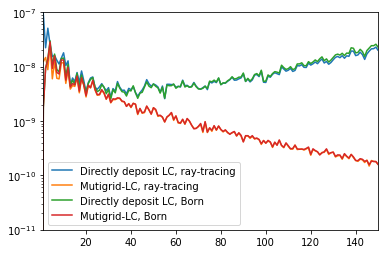

In [122]:
pyplot.plot(hp.sphtfunc.anafast(-(g_cone.DA()-0.004)/0.004))
pyplot.plot(hp.sphtfunc.anafast(-(g_mg.DA()-0.004)/0.004))
pyplot.plot(hp.sphtfunc.anafast(k_cone_b))

pyplot.plot(hp.sphtfunc.anafast(k_mg_b))

pyplot.xlim(1,150)
pyplot.ylim(1e-11,1e-7)
pyplot.legend(['Directly deposit LC, ray-tracing','Mutigrid-LC, ray-tracing','Directly deposit LC, Born',
               'Mutigrid-LC, Born'
              ])
pyplot.yscale('log')

In [120]:
k1.max()

0.009661534199087066

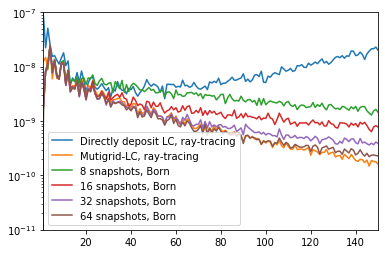

In [123]:
pyplot.plot(hp.sphtfunc.anafast(-(g_cone.DA()-0.004)/0.004))
pyplot.plot(hp.sphtfunc.anafast(-(g_mg.DA()-0.004)/0.004))
pyplot.plot(hp.sphtfunc.anafast(k4))

pyplot.plot(hp.sphtfunc.anafast(k3))
pyplot.plot(hp.sphtfunc.anafast(k2))


pyplot.plot(hp.sphtfunc.anafast(k1))
pyplot.legend(['Directly deposit LC, ray-tracing','Mutigrid-LC, ray-tracing',
              '8 snapshots, Born','16 snapshots, Born','32 snapshots, Born','64 snapshots, Born'])
pyplot.xlim(1,150)
pyplot.ylim(1e-11,1e-7)
pyplot.yscale('log')

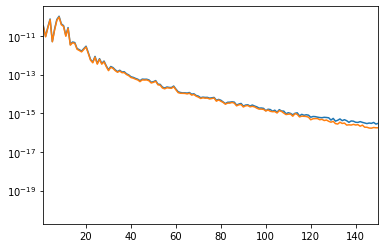

In [176]:

pyplot.plot(hp.sphtfunc.anafast(Phi_cone[400]))
pyplot.plot(hp.sphtfunc.anafast(Phi_mg[400]))



pyplot.xlim(1,150)

pyplot.yscale('log')